In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import MultiLineString, LineString, Point
from shapely.ops import nearest_points, transform
import matplotlib.pyplot as plt
import seaborn as sns
import pyproj

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')
pd.options.display.max_columns = None

In [2]:
# Load Data
matched_flowlines_gdf = gpd.read_file('matched_flowlines.geojson')

In [3]:
matched_flowlines_gdf.crs

<Projected CRS: EPSG:26913>
Name: NAD83 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 108°W and 102°W - onshore and offshore. Canada - Northwest Territories; Nunavut; Saskatchewan. United States (USA) - Colorado; Montana; Nebraska; New Mexico; North Dakota; Oklahoma; South Dakota; Texas; Wyoming.
- bounds: (-108.0, 28.98, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
matched_flowlines_gdf.shape[0]

14922

In [5]:
# Initialize a counter for total number of line segments
total_line_segments = 0

# Iterate over each geometry in the dataset
for geom in matched_flowlines_gdf['geometry']:
    if isinstance(geom, MultiLineString):
        # Count each LineString in the MultiLineString
        total_line_segments += len(geom.geoms)
    elif isinstance(geom, LineString):
        # If it's a single LineString, count it as 1
        total_line_segments += 1

# Output the total number of line segments
print(f"Total number of individual line segments: {total_line_segments}")


Total number of individual line segments: 26361


In [6]:
for geom in matched_flowlines_gdf['geometry']:
    if geom.is_empty:
        print("Empty geometry found!")

### Print Global Linestring Min/Max of Multi-line strings

In [7]:
# Create the Geod object in the same scope where you are using it
geod = pyproj.Geod(ellps="WGS84")

matched_flowlines_gdf = matched_flowlines_gdf.to_crs(epsg=4326)

global_min_length = float('inf')
global_max_length = float('-inf')

for geom in matched_flowlines_gdf['geometry']:
    if isinstance(geom, MultiLineString):
        for line in geom.geoms:
            length_m = geod.geometry_length(line)
            if length_m < global_min_length:
                global_min_length = length_m
            if length_m > global_max_length:
                global_max_length = length_m
    elif isinstance(geom, LineString):
        length_m = geod.geometry_length(geom)
        if length_m < global_min_length:
            global_min_length = length_m
        if length_m > global_max_length:
            global_max_length = length_m

print("Global min:", global_min_length)
print("Global max:", global_max_length)

Global min: 0.004899325574340436
Global max: 20140.186871932954


## Frequency Distribution of LineString Lengths

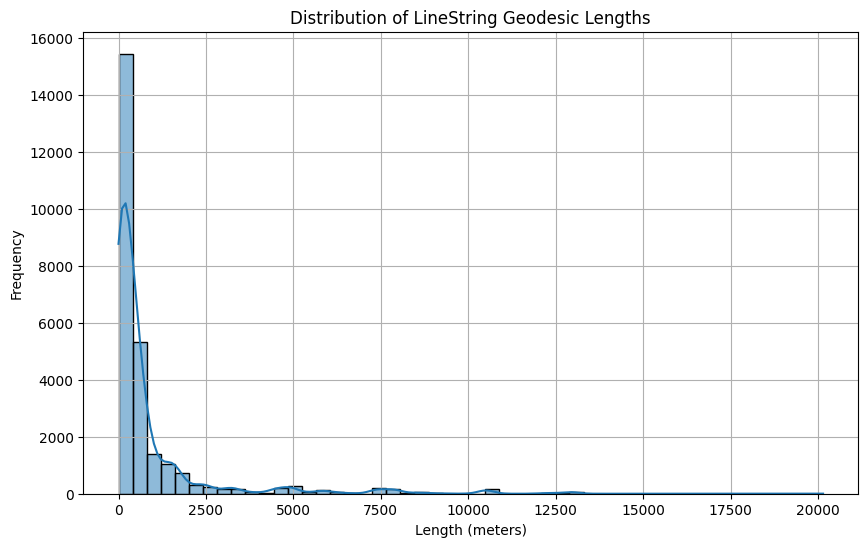

In [8]:
import pyproj
from shapely.geometry import LineString, MultiLineString
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Geod object for WGS84 (or NAD83, but WGS84 is standard for global distances)
# NAD83 and WGS84 are very similar for most practical distances.
geod = pyproj.Geod(ellps="WGS84")

def geodesic_length(line):
    """
    Calculates the geodesic length of a Shapely geometry (LineString) in meters.
    The geometry should be in a geographic CRS (lat/lon).
    """
    return geod.geometry_length(line)

# Initialize a list to store the lengths in meters
line_lengths = []

# Iterate over each geometry in the dataset and calculate geodesic lengths
for geom in matched_flowlines_gdf['geometry']:
    if isinstance(geom, MultiLineString):
        # Iterate over each LineString in the MultiLineString
        for line in geom.geoms:
            line_lengths.append(geodesic_length(line))
    elif isinstance(geom, LineString):
        line_lengths.append(geodesic_length(geom))

# Visualize the distribution of lengths using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(line_lengths, bins=50, kde=True)  # kde=True adds a smoothed density curve
plt.title('Distribution of LineString Geodesic Lengths')
plt.xlabel('Length (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


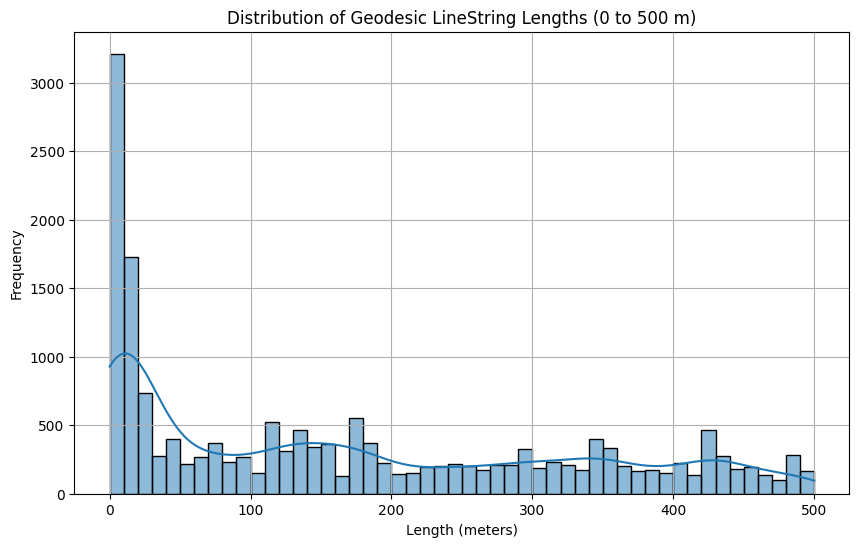

In [9]:
import geopandas as gpd
import pyproj
from shapely.geometry import LineString, MultiLineString
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create a Geod object for WGS84 (common choice; very similar to NAD83 for most practical purposes)
geod = pyproj.Geod(ellps="WGS84")

def geodesic_length(line):
    """
    Calculate the geodesic length of a Shapely geometry (LineString or similar)
    when the geometry is in a geographic CRS (latitude/longitude).
    Returns length in meters.
    """
    return geod.geometry_length(line)

# 2. Calculate geodesic lengths for all LineStrings in the GeoDataFrame
line_lengths = []

for geom in matched_flowlines_gdf['geometry']:
    if isinstance(geom, MultiLineString):
        for line in geom.geoms:
            line_lengths.append(geodesic_length(line))
    elif isinstance(geom, LineString):
        line_lengths.append(geodesic_length(geom))

# 3. Define a maximum length to zoom into (e.g., lengths below 500 meters)
max_length_to_plot = 500  # Adjust as needed

# 4. Filter the lengths
filtered_lengths = [length for length in line_lengths if length <= max_length_to_plot]

# 5. Plot a histogram of the filtered lengths
plt.figure(figsize=(10, 6))
sns.histplot(filtered_lengths, bins=50, kde=True)  # kde=True adds a smoothed density curve
plt.title(f'Distribution of Geodesic LineString Lengths (0 to {max_length_to_plot} m)')
plt.xlabel('Length (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Split each multi-line string segments into 50 meter linestrings

I chose 50 meters as the uniform segment length based on the observed distribution of LineString lengths in the dataset, which is right-skewed, with a significant concentration of shorter lengths in the 0-100 meters range.

By selecting 50 meters, we achieve a balance between:

- Preserving detail for shorter lines: Many of the lines in the dataset are relatively short (as seen in the first bin of the distribution). Choosing 50 meters ensures that we don't excessively subdivide these already short geometries.
- Reasonable subdivision for longer lines: For longer LineString geometries, 50 meters allows for a uniform subdivision that still captures spatial variation without resulting in an overwhelming number of segments.

This length provides a good compromise between accuracy and performance, creating enough segments to maintain the structural integrity of the data while avoiding excessive fragmentation.

In [10]:
import pandas as pd
from shapely.geometry import LineString, MultiLineString
import geopandas as gpd

# Function to split a LineString into uniform-length segments
def split_line(line, segment_length):
    segments = []
    num_segments = int(line.length // segment_length)  # Calculate how many full segments can be made
    # Add full-length segments
    for i in range(num_segments):
        start = line.interpolate(i * segment_length)
        end = line.interpolate((i + 1) * segment_length)
        segments.append(LineString([start, end]))
    # Add the remaining part of the line (if any)
    if line.length % segment_length != 0:
        start = line.interpolate(num_segments * segment_length)
        end = line.interpolate(line.length)
        segments.append(LineString([start, end]))
    return segments  # Return a list of LineString segments

# Function to split MultiLineString into a list of individual LineString segments
def split_multiline(multiline, segment_length):
    segments = []
    for line in multiline.geoms:
        segments.extend(split_line(line, segment_length))  # Add individual LineString segments
    return segments  # Return a list of LineString segments

# Set the desired segment length (e.g., 50 meters)
uniform_segment_length = 50

# Create a new list to hold all split geometries and their corresponding attributes
split_geometries_with_attributes = []

# Iterate over each row in the GeoDataFrame
for idx, row in matched_flowlines_gdf.iterrows():
    geom = row['geometry']
    
    # Split MultiLineString or LineString into segments
    if isinstance(geom, MultiLineString):
        split_segments = split_multiline(geom, uniform_segment_length)
    elif isinstance(geom, LineString):
        split_segments = split_line(geom, uniform_segment_length)
    else:
        continue
    
    # For each segment, create a new row with the same attributes as the original geometry
    for segment in split_segments:
        new_row = row.copy()  # Copy the original row's attributes
        new_row['geometry'] = segment  # Replace the geometry with the new segment
        split_geometries_with_attributes.append(new_row)

# Convert the list of new rows into a new GeoDataFrame
split_gdf = gpd.GeoDataFrame(split_geometries_with_attributes, columns=matched_flowlines_gdf.columns, crs=matched_flowlines_gdf.crs)


# Display overview of new GeoDataFrame
split_gdf


,ACTIONDESCRIPTION,BEDDINGMATERIAL,COMPANY_NAME,CONSTRUCTDATE,Diam_in,ENDLAT,ENDLONG,ENTIRELINEREMOVED,FLOWLINEACTION,FLOWLINEID,Fluid,LOCATIONTYPE,LOCATION_ID,Length_ft,MAXOPPRESSURE,Material,OPERATOR_NUM,Operator,PIPEMATERIAL,RECEIVE_DATE,SHAPE_Length,STARTLAT,STARTLOCATIONID,STARTLONG,Status,TYPEOFFLUIDTRANS,geometry
0,The flowline serving the Emerson 3-29J (05-123...,Native Materials,CRESTONE PEAK RESOURCES OPERATING LLC ...,1983-11-09,2.0,40.109444,-104.909686,None,None,470446.0,Multiphase,Production Facilities,470443.0,1361.28,325.0,Carbon Steel,10633,CRESTONE PEAK RESOURCES OPERATING LLC,Carbon Steel,2023-10-24 08:33:49.223,414.751530,40.105743,NaN,-104.909860,Active,Multiphase,"LINESTRING (-104.90986 40.10574, -104.90969 40..."
1,The flowline (12311399_FL) servicing the Emers...,Native Materials,CRESTONE PEAK RESOURCES OPERATING LLC ...,1983-12-07,2.0,40.109441,-104.909670,True,Out of Service,470445.0,Multiphase,Production Facilities,470443.0,1025.98,250.0,Carbon Steel,10633,CRESTONE PEAK RESOURCES OPERATING LLC,Carbon Steel,2023-10-24 08:33:49.223,312.594254,40.112203,319521.0,-104.909862,Active,Multiphase,"LINESTRING (-104.90986 40.1122, -104.90967 40...."
2,None,None,PETERSON ENERGY OPERATING INC ...,2006-06-05,2.0,40.063138,-105.034086,None,None,466061.0,Crude Oil Emulsion,Production Facilities,318620.0,276.03,NaN,Fiberglass,68710,PETERSON ENERGY OPERATING INC,Carbon Steel,2023-10-24 16:00:01.117,84.099157,40.063823,305594.0,-105.030068,Active,Multiphase,"LINESTRING (-105.03484 40.06362, -105.03413 40..."
3,None,None,PETERSON ENERGY OPERATING INC ...,2007-04-08,2.0,40.063142,-105.034085,None,None,466062.0,Crude Oil Emulsion,Production Facilities,318620.0,276.03,NaN,Fiberglass,68710,PETERSON ENERGY OPERATING INC,Carbon Steel,2023-10-24 16:00:01.117,84.099157,40.060063,305595.0,-105.034795,Active,Multiphase,"LINESTRING (-105.03484 40.06362, -105.03413 40..."
4,None,None,PETERSON ENERGY OPERATING INC ...,2005-05-10,2.0,40.063132,-105.034086,None,None,466063.0,Crude Oil Emulsion,Production Facilities,318620.0,276.03,NaN,Fiberglass,68710,PETERSON ENERGY OPERATING INC,Carbon Steel,2023-10-24 16:00:01.117,84.099157,40.059581,332338.0,-105.029331,Active,Multiphase,"LINESTRING (-105.03484 40.06362, -105.03413 40..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14917,None,None,NOBLE ENERGY INC ...,2001-10-02,3.0,40.397700,-104.647660,None,Registration,455232.0,Multiphase,Production Facilities,446052.0,1413.74,NaN,Carbon Steel,100322,NOBLE ENERGY INC,None,2018-05-04 09:16:11.403,430.739655,40.398090,333012.0,-104.642610,Abandoned,None,"LINESTRING (-104.64261 40.39809, -104.64766 40..."
14918,None,None,NOBLE ENERGY INC ...,2008-02-22,2.0,40.481530,-104.492930,None,Registration,455190.0,Multiphase,Production Facilities,455177.0,527.60,NaN,Carbon Steel,100322,NOBLE ENERGY INC,None,2018-05-10 12:16:07.970,160.751553,40.481330,310572.0,-104.491050,Active,None,"LINESTRING (-104.49104 40.48133, -104.49292 40..."
14919,None,None,NOBLE ENERGY INC ...,2007-08-05,3.0,40.495330,-104.772282,None,Registration,455155.0,Multiphase,Production Facilities,455096.0,2070.49,NaN,Carbon Steel,100322,NOBLE ENERGY INC,None,2018-05-10 13:40:00.330,630.836779,40.489670,306660.0,-104.771610,Abandoned,None,"LINESTRING (-104.77161 40.48967, -104.77228 40..."
14920,None,None,NOBLE ENERGY INC ...,1998-09-27,2.0,40.495330,-104.772282,None,Registration,455156.0,Multiphase,Production Facilities,455096.0,800.31,NaN,Carbon Steel,100322,NOBLE ENERGY INC,None,2018-05-10 13:40:00.330,243.837753,40.493320,306575.0,-104.770310,Active,None,"LINESTRING (-104.7703 40.49331, -104.77204 40...."


In [11]:
split_gdf.to_file("split_flowlines.geojson", driver='GeoJSON')